## Set up paths and imports

In [1]:
import os
if not os.path.exists("./notebooks"):
    %cd ..

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression, lasso_path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from src.log_reg_ccd import LogRegCCD
from src.data.data_loader import SyntheticDataLoader
from src.data.dataset_interface import DataInterface

c:\Users\weron\Pulpit\sem1\aml\projects\proj1\LogRegCCD


In [2]:
di = DataInterface(SyntheticDataLoader(p=0.5, n=1500, d=5, g=0))
di.split_data()
data = di.get_data()
print(data.keys())
X_train, y_train = data['train_data'], data['train_labels']
X_test, y_test = data['test_data'], data['test_labels']
X_valid, y_valid = data['val_data'], data['val_labels']

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


dict_keys(['train_data', 'test_data', 'val_data', 'train_labels', 'test_labels', 'val_labels'])


Test Accuracy: 0.7176
(100,)
(5, 100)


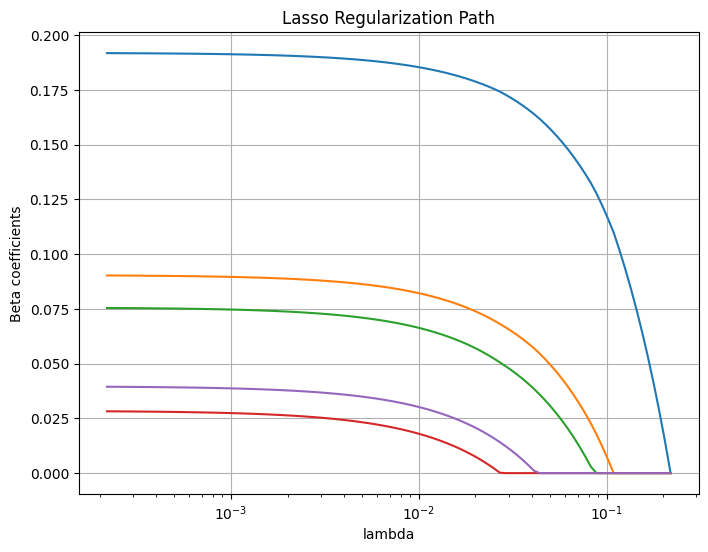

[[1.02421068 0.48881911 0.42663744 0.15547913 0.21746136]]


In [3]:
model = LogisticRegression(penalty='l1', solver='liblinear', C=10)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

def plot_lasso_path(lambdas, betas):
        plt.figure(figsize=(8, 6))
        for i in range(0, betas.shape[0]):
            plt.plot(lambdas, betas[i, :], label=f'{i+1}')
        
        plt.xscale("log")
        plt.xlabel('lambda')
        plt.ylabel('Beta coefficients')
        plt.title('Lasso Regularization Path')
        plt.grid(True)
        plt.show()

alphas_lasso, coefs_lasso, _  = lasso_path(X_train, y_train)
print(alphas_lasso.shape)
print(coefs_lasso.shape)
plot_lasso_path(alphas_lasso, coefs_lasso)
print(model.coef_)

Test Accuracy: 0.7133
Best Beta: [0.16389221 1.02247943 0.48739337 0.4250988  0.1541421  0.21617385]


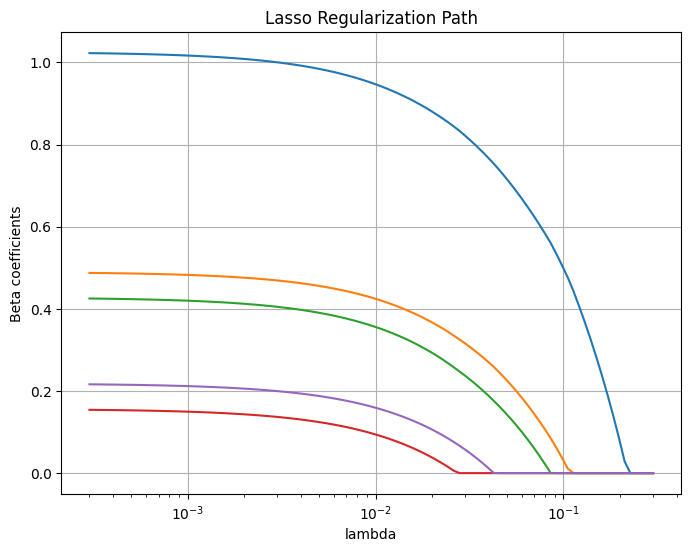

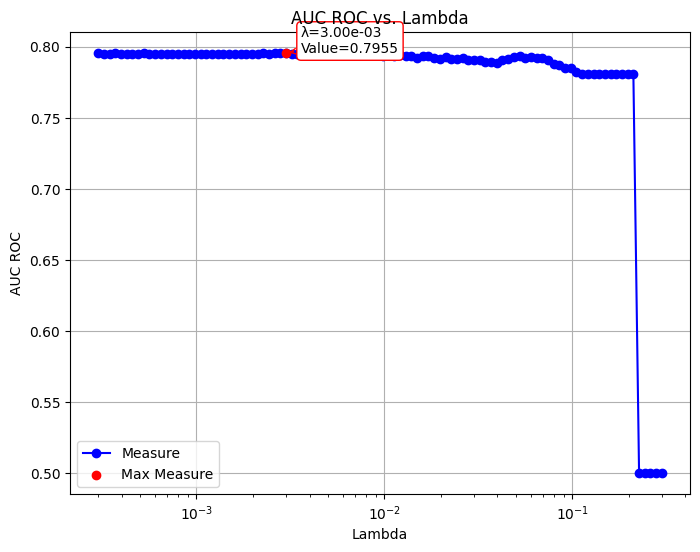

Test Accuracy: 0.6917
Best Beta: [0.16234822 1.00007806 0.46899704 0.40483675 0.13678616 0.19964254]


In [4]:
import src.measures as measure

model = LogRegCCD(verbose=False)
model.fit(X_train, y_train, lam_max=0.3, lam_count=100)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Best Beta: {model.best_beta}")

model.plot_lasso_path()

model.plot(X_valid, y_valid, measure=measure.AUCROC())

model.validate(X_valid, y_valid, measure=measure.AUCROC())
y_pred = model.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Best Beta: {model.best_beta}")
